In [2]:
import finalExamUtilities as fEU

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import scipy.linalg as sp_la
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

We are going to try to *replicate* parts of (https://bmcmedinformdecismak.biomedcentral.com/track/pdf/10.1186/s12911-020-1023-5.pdf), using the same data they used. They "analyzed a dataset containing the medical records of 299 heart failure patients collected at the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad (Punjab, Pakistan), during April–December 2015."
* In the first publication using the data (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181001) the people who collected the data say, "The study was approved by Institutional Review Board of Government College University, Faisalabad-Pakistan and the principles of Helsinki Declaration were followed. Informed consent was taken by the patients from whom the information on required characteristics were collected/accessed."
* I retrieved this data from https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records. According to that site, the data is released under an Attribution 4.0 International (CC BY 4.0) license.
* Here is a description of the variables in this data set:
    - age: age of the patient (years)
    - anaemia: if the patient has anemia (boolean)
    - high blood pressure: if the patient has hypertension (boolean)
    - creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
    - diabetes: if the patient has diabetes (boolean)
    - ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
    - platelets: platelets in the blood (kiloplatelets/mL)
    - sex: woman or man (binary)
    - serum creatinine: level of serum creatinine in the blood (mg/dL)
    - serum sodium: level of serum sodium in the blood (mEq/L)
    - smoking: if the patient smokes or not (boolean)
    - time: follow-up period (days)
    - death event: if the patient died during the follow-up period (boolean)
* We will perform regression, clustering and classification experiments with this data. No models we train will be released; however, the authors of the study we are trying to partially replicate intend their models and findings to be used to help physicians make testing and treatment decisions.

In [3]:
columnsToPlot = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

# Prepare The Data <a class="anchor" id="prepData"></a>

## 1. Load and look at your data <a class="anchor" id="loadData"></a>

* Are there any ethical concerns with using this data for our purpose today?
  * Does the data set contain personally identifiable information?
  * Does the data set contain sensitive variables (eg variables for gender or ethnicity)?
  * Does the license of the data permit its use by us?

Referring to the cell below, which contains a report of the data, please answer:

* How many data points are there?
* How many variables are there?
  * How many qualitative (e.g. boolean, binary)?
  * How many quantitative continuous?
  * How many quantitative discrete?
* Is there a value for each variable for each data point? 
* Do the values make sense? Are there outliers or other insanities?
* Are the variables independent of each other? How do you make that assessment?

In [4]:
columns = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'DEATH_EVENT']
data = np.array(np.genfromtxt('data/heart_failure_clinical_records_dataset.csv', delimiter=',', usecols=[0,1,2,3,4,5,6,7,8,9,10,12], skip_header=1, dtype=float, encoding='utf-8')) 

data columns
 ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'DEATH_EVENT']

Inspect the data
data shape
 (299, 12) 
data type
 float64
missing data: none
data max, min, mean, std
          age   anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  95.000000  1.000000               7861.000000   1.00000          80.000000   
1  40.000000  0.000000                 23.000000   0.00000          14.000000   
2  60.833893  0.431438                581.839465   0.41806          38.083612   
3  11.874901  0.495277                968.663967   0.49324          11.815033   

   high_blood_pressure      platelets  serum_creatinine  serum_sodium  \
0             1.000000  850000.000000          9.400000    148.000000   
1             0.000000   25100.000000          0.500000    113.000000   
2             0.351171  263358.029264          1.393880    136.625418  

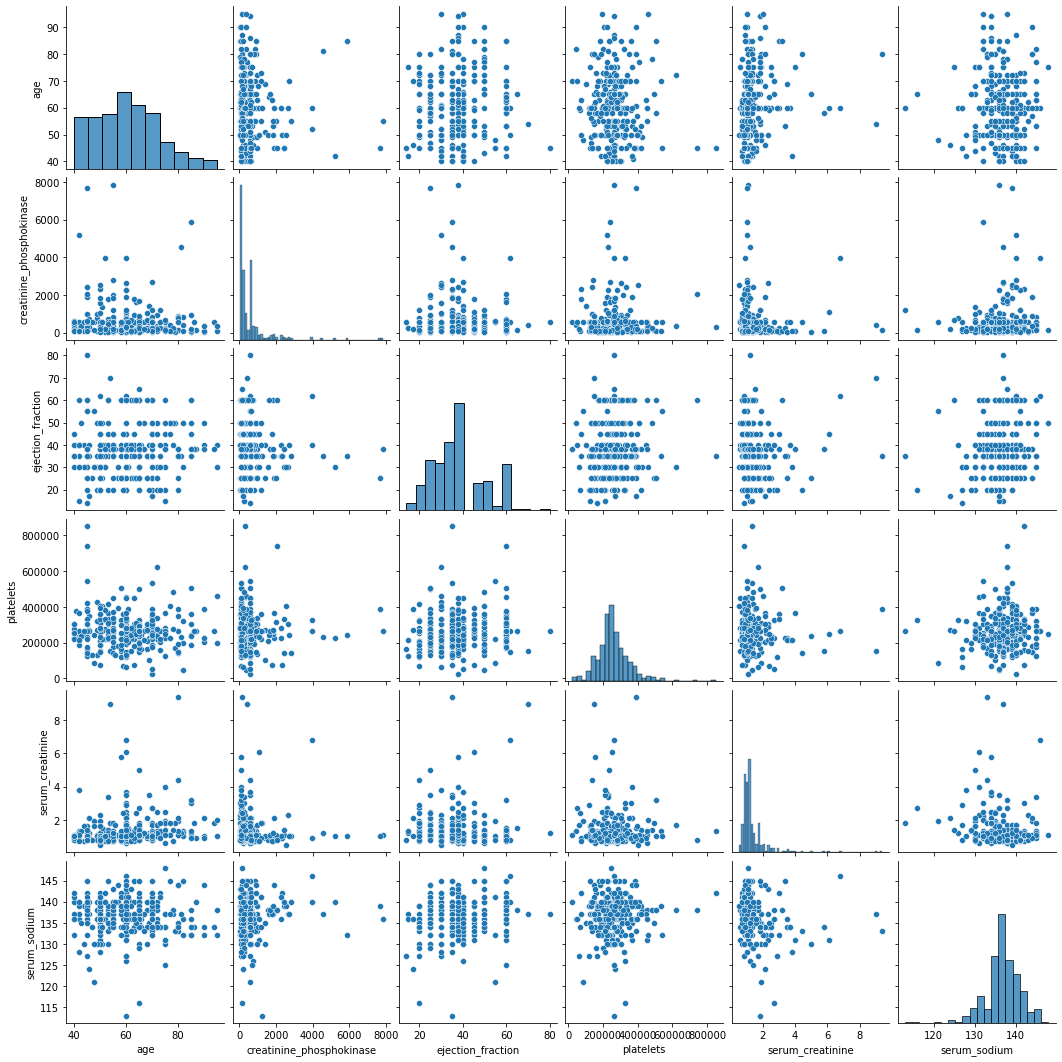

In [5]:
print("data columns\n", columns)
print("\nInspect the data")
print("data shape\n", data.shape, "\ndata type\n", data.dtype)
print("missing data: none")
print("data max, min, mean, std\n", fEU.getSummaryStatistics(data, columns))
sns.pairplot(pd.DataFrame(data, columns=columns), vars=columnsToPlot, kind = "scatter")
plt.show()

## 2. Consider Transforming/Normalizing the Data <a class="anchor" id="normalizeData"></a>

* Looking at this matrix, what basic types of transformation is it doing? (For example: translation, scaling, rotation)
$$\begin{pmatrix} \frac{1}{stdev(var0)} & 0 & 0 & -mean(var0) \\ 0 & \frac{1}{stdev(var1)} & 0 & -mean(var1) \\ 0 & 0 & \frac{1}{stdev(var2)} & -mean(var2) \end{pmatrix}$$
* We need to do some normalization of the heart attack data. Why?
* We are going to do the transformation shown in the matrix above. What is it called?

In [6]:
_, _, transformed = fEU.zScore(data)
print(transformed.shape)

(299, 12)


## 3. Consider Dimensionality Reduction <a class="anchor" id="pcaData"></a>

* In what circumstances do we want to use dimensionality reduction?
* We use PCA for dimensionality reduction. Fill in the blanks:
  * Before using PCA, we have to ___________ the data.
  * To fit a PCA model, we do _______ on the _________ covariance matrix computed over the data.
* Looking at the covariance matrix below, are there any pairs of variables that especially co-vary? If so, describe the nature of the covariance.
* One way to choose how many dimensions to keep is by looking at an elbow plot. Looking at the one below, how many dimensions should we keep for this data set in order to retain 80% of the cumulative explained variance?

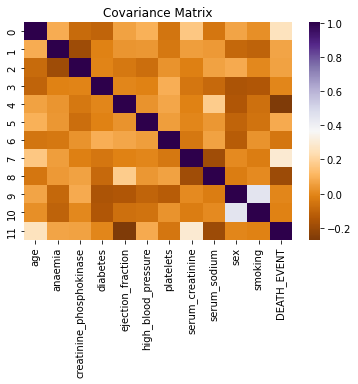

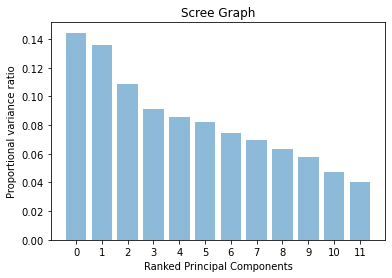

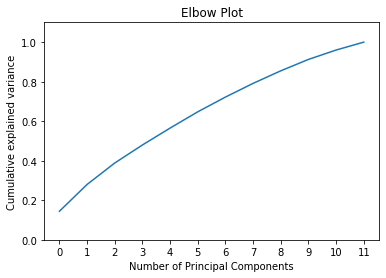

In [7]:
pca = fEU.PCA(centered=True, plot=True)
pca.fit(transformed, columns)

[Go back to the top](#review)


# Model <a class="anchor" id="model"></a>

[Go back to the top](#review)

## 4. Clustering <a class="anchor" id="clustering"></a>

* Clustering requires a distance metric. Name and define a distance metric *other than Euclidean distance*.
* For k-means clustering, we minimize *inertia*. Define inertia.
* k-means clustering is sensitive to the structure of the input data. In what way? How can we fix this type of issue with data structure?
* One way to choose $k$ is by inspecting an elbow plot. Looking at the one below, what would be a good value for $k$ for this data? Why?
* Looking at the two scatter plots - one from the original data and one from the PCA projected data - which is clearer to you? Why?

In [8]:
projected = pca.project(transformed, 7)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


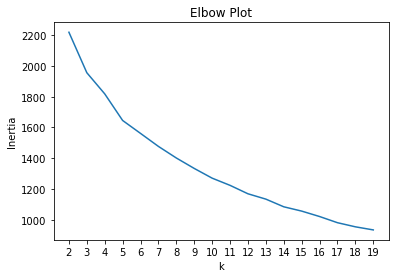

Wall time: 853 ms


In [9]:
%%time

# Clustering on the transformed data, choose k

fEU.fitExploreKMeans(projected, 2, 20, 1)

Wall time: 83.3 ms


Text(0, 0.5, 'serum_creatinine')

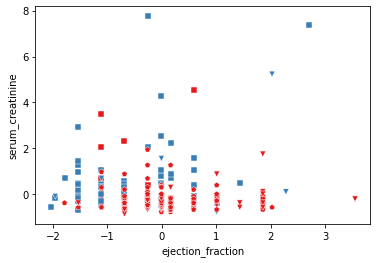

In [10]:
%%time

# Clustering on the transformed data, best k
km = KMeans(n_clusters=3, random_state=0).fit(transformed)
plot = sns.scatterplot(x=transformed[:, 4], y=transformed[:, 7], style=km.labels_, hue=data[:, -1], palette='Set1', legend=False, markers=["v", "s", "p"])
plot.set_xlabel(columns[4])
plot.set_ylabel(columns[7])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


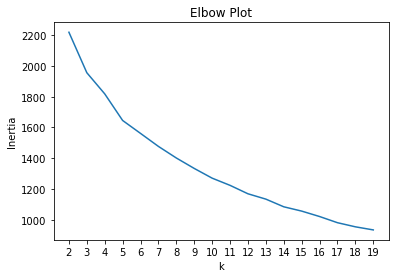

Wall time: 903 ms


In [11]:
%%time

# Clustering on the PCA projected data, choose k

fEU.fitExploreKMeans(projected, 2, 20, 1)

Wall time: 82.4 ms


<AxesSubplot:>

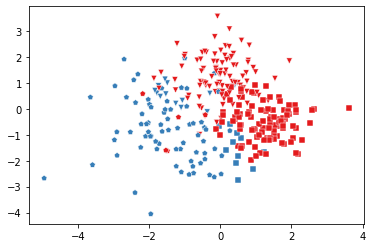

In [12]:
%%time

# Clustering on the PCA projected data, best k
km = KMeans(n_clusters=3, random_state=0).fit(projected)
sns.scatterplot(x=projected[:, 0], y=projected[:, 1], style=km.labels_, hue=data[:, -1], palette='Set1', legend=False, markers=["v", "s", "p"])

# Modeling

* What would be a reasonable choice of dependent variable in this dataset, and why, for:
  * regression?
  * classification?
* What shall we split our data into, and why?
* What do we need to watch out for as we split our data?

In [30]:
# Stratified sampling
def stratifiedSplit(data, depVar, indVars, ratios=[.6, .8]):
    byCategory = [data[data[:,depVar]==k] for k in np.unique(data[:,depVar])]
    if len(byCategory) > 3:
        byCategory = [data]
    trainFeats = []
    devFeats = []
    testFeats = []
    trainYs = []
    devYs = []
    testYs = []
    for category in byCategory:
        np.random.shuffle(category)
        train, dev, test = np.split(category, [int(ratios[0] * len(category)), int(ratios[1] * len(category))])
        train, trainY = train[np.ix_(np.arange(train.shape[0]), indVars)], train[:, depVar]
        dev, devY = dev[np.ix_(np.arange(dev.shape[0]), indVars)], dev[:, depVar]
        test, testY = test[np.ix_(np.arange(test.shape[0]), indVars)], test[:, depVar]
        trainFeats.append(train)
        devFeats.append(dev)
        testFeats.append(test)
        trainYs.append(trainY)
        devYs.append(devY)
        testYs.append(testY)
    return np.vstack(trainFeats), np.vstack(devFeats), np.vstack(testFeats), np.concatenate(trainYs), np.concatenate(devYs), np.concatenate(testYs)

def split(data, columns, depVar, ratios):
    # Set the dependent and independent variables
    indVars = list(range(data.shape[1]))
    indVars.pop(depVar)
    myColumns = columns.copy()
    depName = myColumns.pop(depVar)
    # Split the data, reducing it if necessary
#    print("\nSplit the data, dependent variable ", depVar)
    train, dev, test, trainY, devY, testY = stratifiedSplit(data, depVar, indVars, ratios=ratios)
    return train, dev, test, trainY, devY, testY, myColumns

def splitAndNormalize(data, columns, depVar, ratios):
    train, dev, test, trainY, devY, testY, myColumns = split(data, columns, depVar, ratios)
    # Transform the data
#    print("\nTransform the data")
    translateTransform, scaleTransform, trainTransformed = fEU.zScore(train)
#    print("training data shape", "\n", trainTransformed.shape, "\ntraining data max, min, mean, std\n", fEU.getSummaryStatistics(trainTransformed))
    _, _, devTransformed = fEU.zScore(dev, translateTransform=translateTransform, scaleTransform=scaleTransform)
#    print("\ndev data shape", "\n", devTransformed.shape, "\ndev data max, min, mean, std\n", fEU.getSummaryStatistics(devTransformed))
    _, _, testTransformed = fEU.zScore(test, translateTransform=translateTransform, scaleTransform=scaleTransform)
#    print("\ntest data shape", "\n", testTransformed.shape, "\ntest data max, min, mean, std\n", fEU.getSummaryStatistics(testTransformed))
    return trainTransformed, devTransformed, testTransformed, trainY, devY, testY, myColumns

## 5. Regression <a class="anchor" id="regression"></a>

The authors of the study we are partially replicating report that serum creatinine and ejection fraction are important features for predicting survival. Let's see if we can fit a regression to those two variables.

* Name and define the loss function for regression.
* Least squares is one method for fitting a linear regression model. Least squares for linear regression can be summarized as solving the system of linear equations described by: $\vec{y} = b + m x_i = (1, X_i) \cdot (b, m)$, or $\vec{y} = A \cdot \vec{c}$. In this equation:
  * What is $y$?
  * What do we have to do to the matrix of feature-values to construct $A$?
  * What does $c$ contain?
* I can also use least squares to fit a polynomial regression model. What do I have to do to $A$ to fit a polynomial of degree 2?
* I evaluate the goodness of fit of a regression model by reporting $R^2$ on held-out development or test data. The table below shows $R^2$ on a held-out subset of the heart attack data. What does this value for $R^2$ mean?



In [112]:
columns = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'DEATH_EVENT']
data = np.array(np.genfromtxt('data/heart_failure_clinical_records_dataset.csv', delimiter=',', usecols=[0,1,2,3,4,5,6,7,8,9,10,12], skip_header=1, dtype=float, encoding='utf-8')) 
train, dev, test, trainY, devY, testY, subColumns = split(data, columns, 11, ratios=[.6, .8])

In [113]:
%%time

# Linear regression on the training data

lr1 = LinearRegression().fit(train, trainY)
print(lr1.score(dev, devY))

0.2803295221260508
Wall time: 2.13 ms


In [114]:
%%time

# Polynomial regresson the transformed data, degree 2

pf = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = True)
polynomial2Train = pf.fit_transform(train)
lr2 = LinearRegression().fit(polynomial2Train, trainY)
polynomial2Dev = pf.fit_transform(dev)
print(lr2.score(polynomial2Dev, devY))

-2.6582570348479377
Wall time: 4.83 ms


But there's more!

I can make the regression model "classify" by rounding (the absolute value of) the output.

As a *classifier*, how accurate are these regression models?

In [122]:
def accuracy(y, yhat):
    return np.mean([1 if yi == yhati else 0 for yi, yhati in zip(y, yhat)])

yhat = lr1.predict(dev)
for i in range(len(devY)):
    print(np.round(yhat[i], 3), "&", devY[i], "\\\\")
print(accuracy(np.round(np.abs(lr1.predict(dev))), devY))
print(accuracy(np.round(np.abs(lr2.predict(polynomial2Dev))), devY))

0.204 & 0.0 \\
0.209 & 0.0 \\
0.098 & 0.0 \\
0.433 & 0.0 \\
0.397 & 0.0 \\
0.311 & 0.0 \\
0.249 & 0.0 \\
0.313 & 0.0 \\
0.361 & 0.0 \\
-0.062 & 0.0 \\
-0.118 & 0.0 \\
0.393 & 0.0 \\
0.37 & 0.0 \\
0.25 & 0.0 \\
0.343 & 0.0 \\
0.187 & 0.0 \\
0.541 & 0.0 \\
-0.071 & 0.0 \\
-0.1 & 0.0 \\
0.284 & 0.0 \\
0.381 & 0.0 \\
0.07 & 0.0 \\
0.165 & 0.0 \\
0.164 & 0.0 \\
-0.023 & 0.0 \\
0.719 & 0.0 \\
0.399 & 0.0 \\
0.165 & 0.0 \\
0.241 & 0.0 \\
0.453 & 0.0 \\
0.542 & 0.0 \\
0.467 & 0.0 \\
0.24 & 0.0 \\
0.083 & 0.0 \\
0.339 & 0.0 \\
-0.038 & 0.0 \\
0.226 & 0.0 \\
0.458 & 0.0 \\
0.373 & 0.0 \\
0.236 & 0.0 \\
0.119 & 0.0 \\
0.302 & 1.0 \\
0.407 & 1.0 \\
0.402 & 1.0 \\
0.482 & 1.0 \\
0.495 & 1.0 \\
0.767 & 1.0 \\
0.451 & 1.0 \\
0.646 & 1.0 \\
0.556 & 1.0 \\
0.383 & 1.0 \\
0.455 & 1.0 \\
0.478 & 1.0 \\
0.414 & 1.0 \\
1.326 & 1.0 \\
0.371 & 1.0 \\
0.533 & 1.0 \\
0.917 & 1.0 \\
0.392 & 1.0 \\
0.308 & 1.0 \\
0.7333333333333333
0.6333333333333333


[Go back to the top](#review)

## 6. Classification Evaluation <a class="anchor" id="classificationEvaluation"></a>

* In addition to accuracy, we often create confusion matrices for a classifier.
  * Draw a confusion matrix and label the cells corresponding to true positives, true negatives, false positives and false negatives
  * Looking at the confusion matrix above, what can we say about the classes in this model?
  * Define true positive rate and false positive rate.
  * What is a ROC curve? How is it related to AUC?
  * For a multiclass classifier, what is a variant on the vanilla confusion matrix that we can use?

[Go back to the top](#review)

## 7. K-nearest neighbors <a class="anchor" id="knn"></a>

* How does the *fit* function work for k-nearest neighbors?
* How does the *predict* function work?
* One way to choose a value of $k$ is by looking at an elbow plot. Looking at the elbow plot below, what value of k would you choose for this data and why?

In [129]:
columns = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'DEATH_EVENT']
data = np.array(np.genfromtxt('data/heart_failure_clinical_records_dataset.csv', delimiter=',', usecols=[0,1,2,3,4,5,6,7,8,9,10,12], skip_header=1, dtype=float, encoding='utf-8')) 
transformedTrain, transformedDev, transformedTest, trainY, devY, testY, subColumns = splitAndNormalize(data, columns, 11, ratios=[.6, .8])

2
4
6
8
10
12
14
16
18
20
22
24
26
28


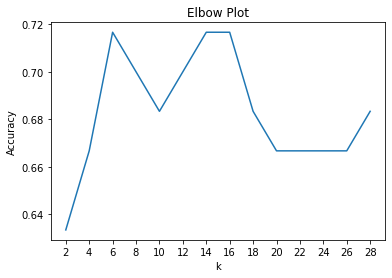

Wall time: 122 ms


In [130]:
%%time

# Fit a kNN to the transformed train data, choose k using dev data; this is hyperparameter tuning

fEU.fitExploreKNN(transformedTrain, trainY, transformedDev, devY, 2, 30, 2)

In [128]:
%%time

# Fit a kNN to the transformed train data, best k, test using test data

knn = KNeighborsClassifier(n_neighbors=6).fit(transformedTrain, trainY)
print(knn.score(transformedTest, testY))
print(confusion_matrix(testY, knn.predict(transformedTest)))

0.6721311475409836
[[40  1]
 [19  1]]
Wall time: 7.38 ms


## 7.  Naive Bayes <a class="anchor" id="nb"></a>

* State Bayes rule.
* In Bayes rule, which parts are the posterior, prior, likelihood and evidence?
* Why do we call a Naive Bayes model "naive"? What does this allow us to do?
* A simple Naive Bayes model is based on relative frequencies of values of the variables in the training data. 
  * How can we account for values of variables we may not see for a particular class at train time?
  * The estimated probabilities output via this method, for any non-trivial number of variable values, will be very small. How can we handle this?
  * If a variable is quantitative (continuous or discrete) we can fit a Naive Bayes model using a probability density function for the variable. Name and define a probability distribution commonly used in this way.

0.639344262295082
[[37  4]
 [18  2]]


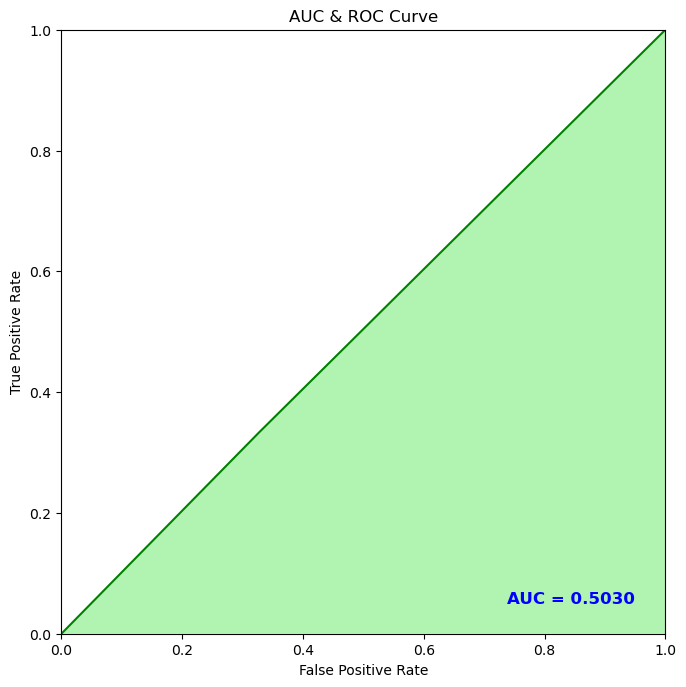

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Wall time: 124 ms


In [131]:
%%time

# Fit a naive Bayes model to the transformed train data, test using test data

gnb = GaussianNB().fit(transformedTrain, trainY)
print(gnb.score(transformedTest, testY))
print(confusion_matrix(testY, gnb.predict(transformedTest)))
fEU.aucRoc(gnb.predict(transformedTest), testY)
print(testY, gnb.predict(transformedTest))

[Go back to the top](#review)

# 8. RBF Networks <a class="anchor" id="rbfNetworks"></a>

* What is a radial basis function?
* What is the structure of a RBF network?
* In this course, what type of activation function did we define for the hidden nodes?
* What are the steps to training a RBF network?
* For what types of modeling can we use a RBF network?

Let's think about training a RBF network to determine whether a "death event" is likely to occur.
* How many nodes will be in the input layer?
* How many nodes will be in the output layer?
* Thinking about the k-means clustering we trained on this data earlier, how many nodes would you put in the hidden layer?

## A Worked Example for Regression <a class="anchor" id="rbfRegression"></a>

Which is more accurate, linear regression (see earlier) or regression via RBF network?

In [ ]:
%%time

# Get the number of prototypes; this is hyperparameter tuning

rbf = fEU.RBFNetwork(type="regression")
rbf.explorePrototypes(transformedTrain, 2, 20, 1)

In [ ]:
%%time

rbf.fit(transformedTrain, trainY, 5)
yhat = rbf.predict(transformedDev)
rbf.score(devY, yhat)

## A Worked Example for Classification <a class="anchor" id="rbfClassification"></a>

Which is most accurate, kNN classification, Naive Bayes classification, or classification via RBF network?

In [ ]:
%%time

# Get the number of prototypes; this is hyperparameter tuning

rbf = fEU.RBFNetwork(type="classification")
rbf.explorePrototypes(transformedTrain, 2, 20, 1)

In [ ]:
%%time

rbf.fit(transformedTrain, trainY, 5)
yhat = rbf.predict(transformedTest)
rbf.score(testY, yhat)

# 10. (Extra Credit) The Replication

The researchers in the paper compared many different modeling methods, including linear regression, k nearest neighbors, Naive Bayes and an "artificial neural network". They also explored many combinations of features. They report results averaged over 100 runs of each modeling approach.

We are going to compare linear regression, kNN, Naive Bayes and RBF networks on two combinations of features: all the features (other than time), and only the features x, y and DEATH_EVENT. As in the paper, we report results averaged over 100 runs of each modeling approach; and as in the paper, in each run we split the data into 60% train, 20% dev and 20% test. 

*Unlike* in the paper, for modeling approaches that do not require hyperparameter tuning, we still only train on train and test on test. Which of our approaches require hyperparameter tuning in each round?

The table and boxplot below show our results. 
* Overall, which modeling approach is better? Explain your choice.
* In general, do we get better results with the reduced or the full feature set? Explain your choice.
* Overfitting

In [132]:
columns = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'DEATH_EVENT']
data = np.array(np.genfromtxt('data/heart_failure_clinical_records_dataset.csv', delimiter=',', usecols=[0,1,2,3,4,5,6,7,8,9,10,12], skip_header=1, dtype=float, encoding='utf-8')) 
transformedTrain, transformedDev, transformedTest, trainY, devY, testY, subColumns = splitAndNormalize(data, columns, 11, ratios=[.6, .8])

In [133]:
def score(yhat, y):
    cm = confusion_matrix(y, yhat)
    tpr = cm[1,1]/(cm[1,0]+cm[1,1])
    tnr = cm[0,0]/(cm[0,0]+cm[0,1])
    return accuracy(np.abs(np.round(yhat)), y), tpr, tnr               
               
kNNKs = []
rbfKs = []

knnAcc = []
nbAcc = []
lrAcc = []
rbfAcc = []

knnTPR = []
nbTPR = []
lrTPR = []
rbfTPR = []

knnTNR = []
nbTNR = []
lrTNR = []
rbfTNR = []

redkNNKs = []
redrbfKs = []

redknnAcc = []
rednbAcc = []
redlrAcc = []
redrbfAcc = []

redknnTPR = []
rednbTPR = []
redlrTPR = []
redrbfTPR = []

redknnTNR = []
rednbTNR = []
redlrTNR = []
redrbfTNR = []
for i in range(100):
    transformedTrain, transformedDev, transformedTest, trainY, devY, testY, subColumns = splitAndNormalize(data, columns, 11, ratios=[.6, .8])
    reducedTrain =  transformedTrain[np.ix_(np.arange(transformedTrain.shape[0]), [4,7])]
    reducedDev =  transformedDev[np.ix_(np.arange(transformedDev.shape[0]), [4,7])]
    reducedTest =  transformedTest[np.ix_(np.arange(transformedTest.shape[0]), [4,7])]

    kNNHyperScores = []
    for j in range(2,15):
        knn = KNeighborsClassifier(n_neighbors=j).fit(transformedTrain, trainY)
        kNNHyperScores.append(knn.score(transformedDev, devY))
    k = np.argmax(np.round(kNNHyperScores, 3))+2
    kNNKs.append(k)
    knn = KNeighborsClassifier(n_neighbors=k).fit(transformedTrain, trainY)
    acc, tpr, tnr = score(knn.predict(transformedTest), testY)
    knnAcc.append(acc)
    knnTPR.append(tpr)
    knnTNR.append(tnr)

    gnb = GaussianNB().fit(transformedTrain, trainY)
    acc, tpr, tnr = score(gnb.predict(transformedTest), testY)
    nbAcc.append(acc)
    nbTPR.append(tpr)
    nbTNR.append(tnr)

    lr = LinearRegression().fit(transformedTrain, trainY)
    acc, tpr, tnr = score(np.abs(np.round(lr.predict(transformedTest))), testY)
    lrAcc.append(acc)
    lrTPR.append(tpr)
    lrTNR.append(tnr)

    rbf = fEU.RBFNetwork(type="classification")
    rbfHyperScores = []
    for j in range(2,15):
        rbf.fit(transformedTrain, trainY, k)
        rbfHyperScores.append(rbf.score(rbf.predict(transformedDev), devY))
    k = np.argmax(np.round(rbfHyperScores, 3))+2
    rbfKs.append(k)
    rbf.fit(transformedTrain, trainY, k)
    acc, tpr, tnr = score(rbf.predict(transformedTest), testY)
    rbfAcc.append(acc)
    rbfTPR.append(tpr)
    rbfTNR.append(tnr)
    
    kNNHyperScores = []
    for j in range(2,15):
        knn = KNeighborsClassifier(n_neighbors=j).fit(reducedTrain, trainY)
        kNNHyperScores.append(knn.score(reducedDev, devY))
    k = np.argmax(np.round(kNNHyperScores, 3))+2
    redkNNKs.append(k)
    knn = KNeighborsClassifier(n_neighbors=k).fit(reducedTrain, trainY)
    acc, tpr, tnr = score(knn.predict(reducedTest), testY)
    redknnAcc.append(acc)
    redknnTPR.append(tpr)
    redknnTNR.append(tnr)

    gnb = GaussianNB().fit(reducedTrain, trainY)
    acc, tpr, tnr = score(gnb.predict(reducedTest), testY)
    rednbAcc.append(acc)
    rednbTPR.append(tpr)
    rednbTNR.append(tnr)

    lr = LinearRegression().fit(reducedTrain, trainY)
    acc, tpr, tnr = score(np.abs(np.round(lr.predict(reducedTest))), testY)
    redlrAcc.append(acc)
    redlrTPR.append(tpr)
    redlrTNR.append(tnr)

    rbf = fEU.RBFNetwork(type="classification")
    rbfHyperScores = []
    for j in range(2,15):
        rbf.fit(reducedTrain, trainY, k)
        rbfHyperScores.append(rbf.score(rbf.predict(reducedDev), devY))
    k = np.argmax(np.round(rbfHyperScores, 3))+2
    redrbfKs.append(k)
    rbf.fit(reducedTrain, trainY, k)
    acc, tpr, tnr = score(rbf.predict(reducedTest), testY)
    redrbfAcc.append(acc)
    redrbfTPR.append(tpr)
    redrbfTNR.append(tnr)

In [134]:
print(np.array(kNNKs).mean(), np.array(rbfKs).mean(), np.array(redkNNKs).mean(), np.array(redrbfKs).mean())

6.37 2.0 6.03 2.0


(100, 4)
        kNN  Naive Bayes  Linear Regression  RBF networks
0  0.770492     0.803279           0.836066      0.737705
1  0.557377     0.622951           0.622951      0.622951
2  0.677213     0.705574           0.729836      0.681148
3  0.038773     0.040880           0.043341      0.026062
(100, 4)


<AxesSubplot:>

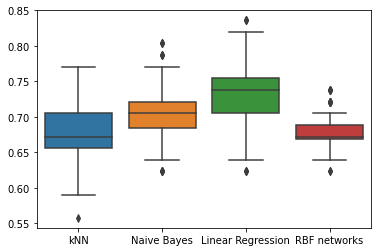

In [135]:
scores = np.array([knnAcc, nbAcc, lrAcc, rbfAcc]).T
print(scores.shape)
print(fEU.getSummaryStatistics(scores, ["kNN", "Naive Bayes", "Linear Regression", "RBF networks"]))

scores = pd.DataFrame(scores, columns=["kNN", "Naive Bayes", "Linear Regression", "RBF networks"])
print(scores.shape)
sns.boxplot(data=scores)

(100, 4)
        kNN  Naive Bayes  Linear Regression  RBF networks
0  0.852459     0.786885           0.770492      0.819672
1  0.622951     0.639344           0.622951      0.573770
2  0.736885     0.709180           0.721967      0.704918
3  0.048096     0.032591           0.027716      0.040489
(100, 4)


<AxesSubplot:>

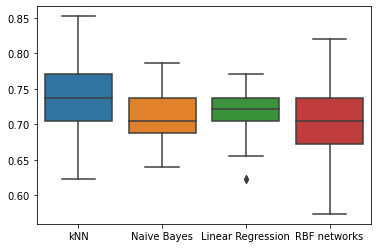

In [136]:
scores = np.array([redknnAcc, rednbAcc, redlrAcc, redrbfAcc]).T
print(scores.shape)
print(fEU.getSummaryStatistics(scores, ["kNN", "Naive Bayes", "Linear Regression", "RBF networks"]))

scores = pd.DataFrame(scores, columns=["kNN", "Naive Bayes", "Linear Regression", "RBF networks"])
print(scores.shape)
sns.boxplot(data=scores)

(100, 4)
        kNN  Naive Bayes  Linear Regression  RBF networks
0  0.450000     0.600000           0.650000      0.300000
1  0.000000     0.100000           0.150000      0.000000
2  0.173500     0.307000           0.400868      0.101500
3  0.103551     0.103204           0.101481      0.057208
(100, 4)


<AxesSubplot:>

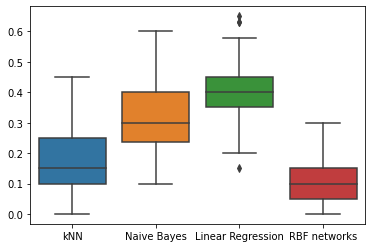

In [137]:
scores = np.array([knnTPR, nbTPR, lrTPR, rbfTPR]).T
print(scores.shape)
print(fEU.getSummaryStatistics(scores, ["kNN", "Naive Bayes", "Linear Regression", "RBF networks"]))

scores = pd.DataFrame(scores, columns=["kNN", "Naive Bayes", "Linear Regression", "RBF networks"])
print(scores.shape)
sns.boxplot(data=scores)

(100, 4)
        kNN  Naive Bayes  Linear Regression  RBF networks
0  0.750000     0.450000           0.450000      0.550000
1  0.150000     0.050000           0.050000      0.000000
2  0.450000     0.223500           0.258500      0.229500
3  0.131149     0.092048           0.074117      0.140729
(100, 4)


<AxesSubplot:>

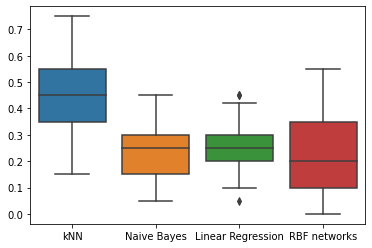

In [138]:
scores = np.array([redknnTPR, rednbTPR, redlrTPR, redrbfTPR]).T
print(scores.shape)
print(fEU.getSummaryStatistics(scores, ["kNN", "Naive Bayes", "Linear Regression", "RBF networks"]))

scores = pd.DataFrame(scores, columns=["kNN", "Naive Bayes", "Linear Regression", "RBF networks"])
print(scores.shape)
sns.boxplot(data=scores)

(100, 4)
        kNN  Naive Bayes  Linear Regression  RBF networks
0  1.000000     1.000000           1.000000      1.000000
1  0.780488     0.804878           0.780488      0.878049
2  0.922927     0.900000           0.891707      0.963902
3  0.051937     0.046852           0.047083      0.029967
(100, 4)


<AxesSubplot:>

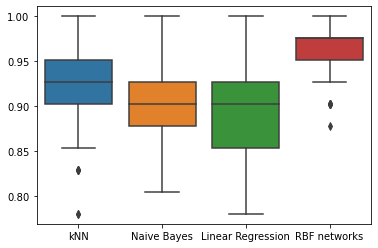

In [139]:
scores = np.array([knnTNR, nbTNR, lrTNR, rbfTNR]).T
print(scores.shape)
print(fEU.getSummaryStatistics(scores, ["kNN", "Naive Bayes", "Linear Regression", "RBF networks"]))

scores = pd.DataFrame(scores, columns=["kNN", "Naive Bayes", "Linear Regression", "RBF networks"])
print(scores.shape)
sns.boxplot(data=scores)

(100, 4)
        kNN  Naive Bayes  Linear Regression  RBF networks
0  1.000000     1.000000           1.000000      1.000000
1  0.707317     0.853659           0.829268      0.731707
2  0.876829     0.946098           0.948780      0.936829
3  0.061255     0.033495           0.037230      0.050823
(100, 4)


<AxesSubplot:>

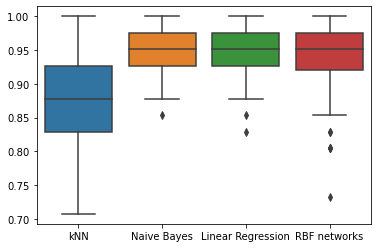

In [140]:
scores = np.array([redknnTNR, rednbTNR, redlrTNR, redrbfTNR]).T
print(scores.shape)
print(fEU.getSummaryStatistics(scores, ["kNN", "Naive Bayes", "Linear Regression", "RBF networks"]))

scores = pd.DataFrame(scores, columns=["kNN", "Naive Bayes", "Linear Regression", "RBF networks"])
print(scores.shape)
sns.boxplot(data=scores)